Starting ISCX Botnet Detection Application 


 -- RF trained in 132.1 seconds
 -- Calibrated LSVC trained in 17.2 seconds.
 -- Calibrated SGD trained in 317.1 seconds.
 -- Logistic Regression trained in 601.5 seconds.
 -- Ensemble trained in 678.7 seconds.



<RF report>
              precision    recall  f1-score   support

       Neris       0.91      0.98      0.94     69729
      Normal       0.97      0.94      0.95    108791
       Other       0.96      0.90      0.93     20733
       Virut       0.57      0.35      0.44       747

    accuracy                           0.95    200000
   macro avg       0.85      0.79      0.82    200000
weighted avg       0.95      0.95      0.95    200000


<LSVC report>
              precision    recall  f1-score   support

       Neris       0.65      0.50      0.56     69729
      Normal       0.79      0.77      0.78    108791
       Other       0.12      0.23      0.15     20733
       Virut       0.00      0.00      0.00       747

    ac

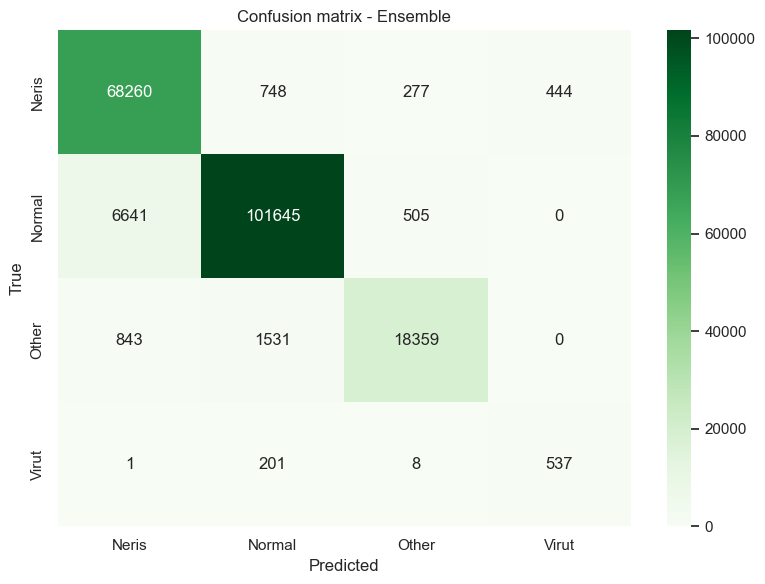

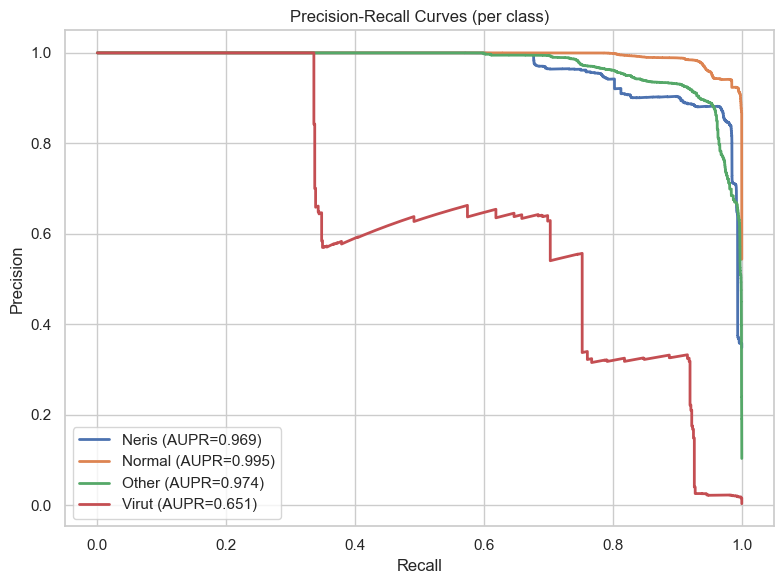

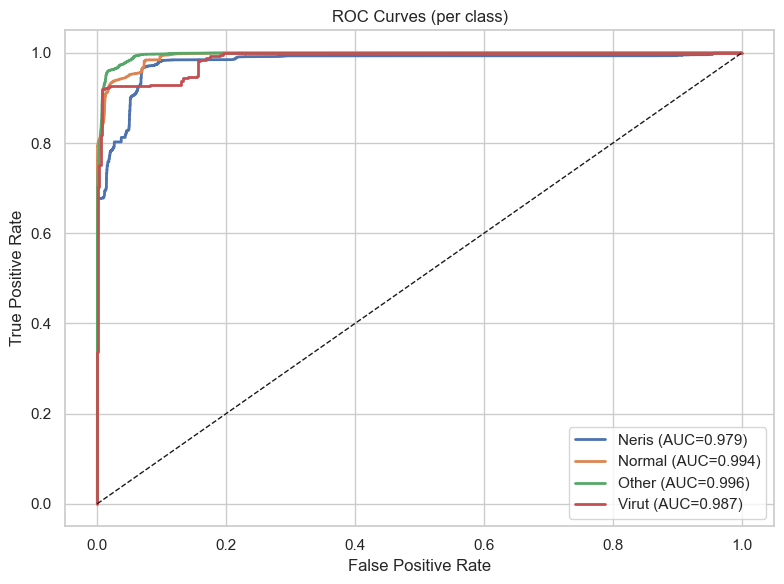

done; saved semi_supervised_summary.json


In [10]:
# ------------------- #
#      Library        #
# ------------------- #
import os, time, json
from collections import Counter
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import boxcox
from sklearn.preprocessing import RobustScaler
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
#from sklearn.ensemble import GradientBoostingClassifier
from sklearn.svm import LinearSVC
from sklearn.linear_model import SGDClassifier, LogisticRegression
from sklearn.calibration import CalibratedClassifierCV
from sklearn.metrics import classification_report, confusion_matrix, precision_recall_curve, roc_curve, auc, roc_auc_score
from sklearn.preprocessing import label_binarize
from imblearn.over_sampling import SMOTE

sns.set(style="whitegrid")

# ------------------- #
#  GLobal Parameters  #
# ------------------- #
TRAIN_PATH = r'X:\Dissertacao\python_projects\dataset\ISCX-Bot-2014\ISCX_csv\Testing_file.csv'
TEST_PATH = r'X:\Dissertacao\python_projects\dataset\ISCX-Bot-2014\ISCX_csv\Training_file.csv'
SAMPLE_SIZE = 200_000
RANDOM_STATE = 42
NUM_FEATURES = []
OUTPUT_SUMMARY = "semi_supervised_summary.json"

def safe_boxcox(series):
    arr = np.asarray(series.fillna(0.0).astype(float) + 1e-6)
    try:
        out, _ = boxcox(arr + 1e-6)
        return out
    except Exception:
        return np.log1p(arr)

def safe_sample(df, n, seed=RANDOM_STATE):
    if n >= len(df):
        return df.sample(frac=1.0, random_state=seed).reset_index(drop=True)
    return df.sample(n=n, random_state=seed).reset_index(drop=True)

def ensure_numeric(df, cols):
    for c in cols:
        if c not in df.columns:
            df[c] = 0.0
        df[c] = pd.to_numeric(df[c], errors='coerce').fillna(0.0)
    return df
    
# ------------------- #
#    Config/Paths     #
# ------------------- #
print("Starting ISCX Botnet Detection Application \n\n")
df_train = pd.read_csv(TRAIN_PATH, low_memory=False, encoding='ISO-8859-1')
df_test  = pd.read_csv(TEST_PATH,  low_memory=False, encoding='ISO-8859-1')

# ------------------- #
#    Basic Cleanup    #
# ------------------- #
for df in (df_train, df_test):
    for col in ['Time','Source','Destination','Length']:
        if col in df.columns:
            df.dropna(subset=[col], inplace=True)
    if 'Info' in df.columns:
        df['Info'] = df['Info'].fillna("Unknown")

# ------------------- #
#  Build GLobal Maps  #
# ------------------- #
def combined_map(train, test, col):
    if col not in train.columns or col not in test.columns:
        train[col] = train.get(col, "Unknown").astype(str)
        test[col]  = test.get(col, "Unknown").astype(str)
    all_vals = pd.concat([train[col].astype(str), test[col].astype(str)], axis=0)
    uniques = pd.unique(all_vals)
    mapping = {v:i for i,v in enumerate(uniques)}
    train[col + "_enc"] = train[col].astype(str).map(mapping).fillna(-1).astype(int)
    test[col + "_enc"]  = test[col].astype(str).map(mapping).fillna(-1).astype(int)
    return mapping

combined_map(df_train, df_test, 'Protocol')
combined_map(df_train, df_test, 'Source')
combined_map(df_train, df_test, 'Destination')

# ------------------- #
# Feature Engineering #
# ------------------- #
def build_features(df):
    df = df.copy()
    src = 'Source_enc' if 'Source_enc' in df.columns else 'Source'
    dst = 'Destination_enc' if 'Destination_enc' in df.columns else 'Destination'
    if 'Time' in df.columns:
        df['Time'] = pd.to_numeric(df['Time'], errors='coerce').fillna(0.0)
        df['Time_Diff'] = df.groupby(src)['Time'].diff().fillna(df.groupby(src)['Time'].transform('median')).fillna(0.0)
    else:
        df['Time_Diff'] = 0.0
    def pkt_rate_series(s):
        a = s.dropna().values
        if a.size < 2:
            return pd.Series(np.zeros(len(s)), index=s.index)
        q1, q3 = np.percentile(a, [25,75])
        iqr = max(q3 - q1, 1e-9)
        cl = np.clip(a, q1 - 1.5*iqr, q3 + 1.5*iqr)
        denom = cl.max() - cl.min()
        if denom <= 1e-6:
            rate = np.zeros_like(a)
        else:
            rate = np.full_like(a, cl.size / denom, dtype=float)
        out = pd.Series(rate, index=s.dropna().index)
        return out.reindex(s.index).fillna(0.0)
    if 'Time' in df.columns:
        df['Packet_Rate'] = df.groupby(src)['Time'].transform(lambda s: pkt_rate_series(s)).fillna(0.0)
    else:
        df['Packet_Rate'] = 0.0
    df['Inter_Arrival_Time'] = df.groupby(src)['Time_Diff'].transform(lambda s: s.rolling(10, min_periods=1).mean()).fillna(0.0).clip(lower=1e-6)
    df['Burst_Rate'] = np.where(df['Inter_Arrival_Time']>1e-6, 1.0/df['Inter_Arrival_Time'], 0.0)
    df['Length'] = pd.to_numeric(df.get('Length', 0)).fillna(0)
    df['Length_Mean'] = df.groupby(src)['Length'].transform('mean').fillna(df['Length'].mean() if 'Length' in df.columns else 0.0)
    df['Length_Std']  = df.groupby(src)['Length'].transform('std').fillna(0.0)
    df['Pkt_Per_Src'] = df.groupby(src)['Length'].transform('count').fillna(0).astype(int)
    if 'Time' in df.columns:
        df['Session_Dur_Src'] = df.groupby(src)['Time'].transform(lambda x: x.max() - x.min()).fillna(0.0)
        df['Session_Dur_Dst'] = df.groupby(dst)['Time'].transform(lambda x: x.max() - x.min()).fillna(0.0)
    else:
        df['Session_Dur_Src'] = 0.0
        df['Session_Dur_Dst'] = 0.0
    df['Bytes_Per_Session_Src'] = df.groupby(src)['Length'].transform('sum').fillna(0.0)
    df['Bytes_Per_Session_Dst'] = df.groupby(dst)['Length'].transform('sum').fillna(0.0)
    df['Packets_Per_Session_Src'] = df['Pkt_Per_Src']
    df['Packets_Per_Session_Dst'] = df.groupby(dst)['Length'].transform('count').fillna(0).astype(int)
    df['Log_IATime'] = np.log1p(df['Inter_Arrival_Time'])
    df['Log_BRate']  = np.log1p(df['Burst_Rate'].clip(lower=0))
    df['BoxCox_Length'] = safe_boxcox(df['Length']) if 'Length' in df.columns else np.zeros(len(df))
    df['BoxCox_PRate']  = safe_boxcox(df['Packet_Rate'])
    df['Rate_to_Length'] = df['Burst_Rate'] / (df['BoxCox_Length'] + 1e-6)
    df['IAT_to_Session'] = df['Inter_Arrival_Time'] / (df['Session_Dur_Src'] + 1e-6)
    df['Burst_Variability'] = df['Burst_Rate'].rolling(5, min_periods=1).std().fillna(0.0).values
    df['Pkt_Rate_Change']  = df['Packet_Rate'].diff().fillna(0.0).values
    features = ['Time_Diff','Log_IATime','Log_BRate','BoxCox_Length','BoxCox_PRate','Length_Mean','Length_Std','Pkt_Per_Src','Session_Dur_Src','Session_Dur_Dst','Rate_to_Length','IAT_to_Session','Burst_Variability','Pkt_Rate_Change','Bytes_Per_Session_Src','Packets_Per_Session_Src']
    df = ensure_numeric(df, features)
    return df, features

df_train, features_train = build_features(df_train)
df_test, features_test   = build_features(df_test)
NUM_FEATURES = list(dict.fromkeys(features_train + features_test))

df_train_sample = safe_sample(df_train, SAMPLE_SIZE)
df_test_sample  = safe_sample(df_test, SAMPLE_SIZE)

# ------------------- #
#        Scale        #
# ------------------- #
scaler = RobustScaler()
scaler.fit(df_train_sample[NUM_FEATURES])
X_train = pd.DataFrame(scaler.transform(df_train_sample[NUM_FEATURES]), columns=NUM_FEATURES, index=df_train_sample.index)
X_test  = pd.DataFrame(scaler.transform(df_test_sample[NUM_FEATURES]),  columns=NUM_FEATURES, index=df_test_sample.index)

# ---------------------------- #
# Set Percentiles for features #
# ---------------------------- #
percentiles = [5,10,30,50,70,80,90,95]
p = {}

features_for_percentiles = ["Pkt_Per_Src","Burst_Rate","Session_Dur_Src",
                            "Inter_Arrival_Time","BoxCox_Length","Rate_to_Length",
                            "IAT_to_Session","Burst_Variability","Pkt_Rate_Change",
                            "Bytes_Per_Session_Src","Packets_Per_Session_Src"]

for feat in features_for_percentiles:
    if feat in df_train_sample.columns:
        vals = df_train_sample[feat].dropna().values
        if vals.size == 0:
            p[feat] = {perc: 0.0 for perc in percentiles}
        else:
            q = np.percentile(vals, percentiles)
            p[feat] = {perc: float(x) for perc, x in zip(percentiles, q)}
    else:
        p[feat] = {perc: 0.0 for perc in percentiles}

def pp(feat, perc):
    return p.get(feat, {}).get(perc, 0.0)

# -------------------- #
#   Botnet Profiling   #
# -------------------- #
botnet_profiles = {
    "Normal": {
    "Pkt_Per_Src": (0, np.percentile(df_train["Pkt_Per_Src"], 50)),
    "Burst_Rate": (0, np.percentile(df_train["Burst_Rate"], 35)),
    "Session_Dur_Src": (np.percentile(df_train["Session_Dur_Src"], 40), np.inf)
    },
    
    "Neris": {
        "Pkt_Per_Src": (pp("Pkt_Per_Src", 80), np.inf),
        "Rate_to_Length": (pp("Rate_to_Length", 70), np.inf),
        "Burst_Rate": (pp("Burst_Rate", 50), np.inf)
    },
    "Virut": {
        "BoxCox_Length": (pp("BoxCox_Length", 75), np.inf),
        "Burst_Rate": (pp("Burst_Rate", 40), pp("Burst_Rate", 60))
    },
    "Zeus": {
        "Inter_Arrival_Time": (pp("Inter_Arrival_Time", 10), pp("Inter_Arrival_Time", 40)),
        "IAT_to_Session": (pp("IAT_to_Session", 20), pp("IAT_to_Session", 75)),
        "Burst_Variability": (pp("Burst_Variability", 5), pp("Burst_Variability", 60))
    },
    "Other": {
        "Pkt_Rate_Change": (pp("Pkt_Rate_Change", 50),pp("Pkt_Rate_Change", 85)),
        "Burst_Variability": (pp("Burst_Variability", 60),pp("Burst_Variability", 90))
    }
}

def score_profiles(row, profiles, min_matches=1):
    scores = {}
    for name, rules in profiles.items():
        matches = 0
        total = len(rules)
        for feat, (low, high) in rules.items():
            val = row.get(feat, None)
            if val is None or pd.isna(val):
                continue
            if val >= low and val <= high:
                matches += 1
        scores[name] = (matches, total)
    best = max(scores.items(), key=lambda kv: (kv[1][0], kv[1][1]))
    if best[1][0] >= min_matches and best[1][0] > 0:
        return best[0]
    return "Unknown"

df_train_sample['Pred_Botnet_Profile'] = "Normal"
df_test_sample['Pred_Botnet_Profile']  = "Normal"
mask_t = df_train_sample.apply(lambda r: score_profiles(r, botnet_profiles, min_matches=1) != "Unknown", axis=1)
mask_e = df_test_sample.apply(lambda r: score_profiles(r, botnet_profiles, min_matches=1) != "Unknown", axis=1)
df_train_sample.loc[mask_t, 'Pred_Botnet_Profile'] = df_train_sample.loc[mask_t].apply(lambda r: score_profiles(r, botnet_profiles, min_matches=1), axis=1)
df_test_sample.loc[mask_e, 'Pred_Botnet_Profile']  = df_test_sample.loc[mask_e].apply(lambda r: score_profiles(r, botnet_profiles, min_matches=1), axis=1)
fallback_t = (df_train_sample['Pred_Botnet_Profile'] == "Unknown")
fallback_e = (df_test_sample['Pred_Botnet_Profile']  == "Unknown")
df_train_sample.loc[fallback_t, 'Pred_Botnet_Profile'] = "Other"
df_test_sample.loc[fallback_e, 'Pred_Botnet_Profile'] = "Other"

# -------------------- #
#  Classifiers/Models  #
# -------------------- #
def prepare_rf_df(df_s):
    dfc = df_s.copy()
    dfc['RF_Label'] = dfc['Pred_Botnet_Profile'].fillna("Unknown")
    return dfc

rf_train_df = prepare_rf_df(df_train_sample)
rf_test_df  = prepare_rf_df(df_test_sample)

anom_known = rf_train_df[rf_train_df['RF_Label'] != "Unknown"]
normals = rf_train_df[rf_train_df['RF_Label'] == "Normal"]

if len(anom_known) == 0:
    print("no anomalies to train")
    raise SystemExit

class_counts = anom_known['RF_Label'].value_counts()
min_non_norm = class_counts.min()
n_normals_keep = min(len(normals), int(min_non_norm * max(3, len(class_counts))))
normals_sampled = normals.sample(n=n_normals_keep, random_state=RANDOM_STATE) if len(normals)>0 else pd.DataFrame()
rf_train_ready = pd.concat([anom_known, normals_sampled]).sample(frac=1.0, random_state=RANDOM_STATE).reset_index(drop=True)
rf_train_ready = rf_train_ready[rf_train_ready['RF_Label'] != "Unknown"]

X_train_sup = rf_train_ready[NUM_FEATURES].fillna(0.0)
y_train_sup = rf_train_ready['RF_Label']
X_test_sup  = rf_test_df[NUM_FEATURES].fillna(0.0)
y_test_sup  = rf_test_df['RF_Label']

try:
    sm = SMOTE(random_state=RANDOM_STATE)
    X_bal, y_bal = sm.fit_resample(X_train_sup, y_train_sup)
except Exception:
    X_bal, y_bal = X_train_sup, y_train_sup

# ------------------- #
#     Model Train     #
# ------------------- #
rf = RandomForestClassifier(n_estimators=300, class_weight="balanced_subsample", random_state=RANDOM_STATE, n_jobs=-1)
lsvc_base = LinearSVC(C=0.5, class_weight='balanced', max_iter=5000, random_state=RANDOM_STATE)
lsvc = CalibratedClassifierCV(lsvc_base, cv=3)
sgd_base = SGDClassifier(loss='log_loss', penalty='elasticnet', alpha=1e-4, class_weight='balanced', max_iter=2000, random_state=RANDOM_STATE)
sgd = CalibratedClassifierCV(sgd_base, cv=3)
logreg = LogisticRegression(max_iter=5000, class_weight='balanced', random_state=RANDOM_STATE)

t0 = time.time()
rf.fit(X_bal, y_bal)
t1 = time.time()
print(f" -- RF trained in {(t1-t0):.1f} seconds")

t0 = time.time()
lsvc.fit(X_bal, y_bal)
t1 = time.time()
print(f" -- Calibrated LSVC trained in {(t1-t0):.1f} seconds.")

t0 = time.time()
sgd.fit(X_bal, y_bal)
t1 = time.time()
print(f" -- Calibrated SGD trained in {(t1-t0):.1f} seconds.")

t0 = time.time()
logreg.fit(X_bal, y_bal)
t1 = time.time()
print(f" -- Logistic Regression trained in {(t1-t0):.1f} seconds.")

estimators = [('rf', rf), ('lsvc', lsvc), ('sgd', sgd), ('lr', logreg)]
ensemble = VotingClassifier(estimators=estimators, voting='soft', weights=[3,1,1,1], n_jobs=-1)
t0 = time.time()
ensemble.fit(X_bal, y_bal)
t1 = time.time()
print(f" -- Ensemble trained in {(t1-t0):.1f} seconds.\n\n")

y_pred_rf  = rf.predict(X_test_sup)
y_pred_lsvc= lsvc.predict(X_test_sup)
y_pred_sgd = sgd.predict(X_test_sup)
y_pred_log = logreg.predict(X_test_sup)
y_pred_ens = ensemble.predict(X_test_sup)

# ------------------- #
#      Results        #
# ------------------- #
print("\n<RF report>")
print(classification_report(y_test_sup, y_pred_rf, zero_division=0))
print("\n<LSVC report>")
print(classification_report(y_test_sup, y_pred_lsvc, zero_division=0))
print("\n<SGD report>")
print(classification_report(y_test_sup, y_pred_sgd, zero_division=0))
print("\n<LogReg report>")
print(classification_report(y_test_sup, y_pred_log, zero_division=0))
print("\n<Ensemble report>")
print(classification_report(y_test_sup, y_pred_ens, zero_division=0))

labels = sorted(list(pd.unique(y_test_sup)))
cm = confusion_matrix(y_test_sup, y_pred_ens, labels=labels)
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=labels, yticklabels=labels, cmap="Greens")
plt.title("Confusion matrix - Ensemble")
plt.ylabel("True")
plt.xlabel("Predicted")
plt.tight_layout()
plt.show()

y_test_binarized = label_binarize(y_test_sup, classes=labels)
n_classes = y_test_binarized.shape[1]
y_score = ensemble.predict_proba(X_test_sup)
precision = dict(); recall = dict(); pr_auc = dict()
fpr = dict(); tpr = dict(); roc_auc = dict()
for i in range(n_classes):
    precision[i], recall[i], _ = precision_recall_curve(y_test_binarized[:, i], y_score[:, i])
    pr_auc[i] = auc(recall[i], precision[i])
    fpr[i], tpr[i], _ = roc_curve(y_test_binarized[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

plt.figure(figsize=(8,6))
for i, lab in enumerate(labels):
    plt.plot(recall[i], precision[i], lw=2, label=f"{lab} (AUPR={pr_auc[i]:.3f})")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curves (per class)")
plt.legend(loc="best")
plt.tight_layout()
plt.show()

plt.figure(figsize=(8,6))
for i, lab in enumerate(labels):
    plt.plot(fpr[i], tpr[i], lw=2, label=f"{lab} (AUC={roc_auc[i]:.3f})")
plt.plot([0,1],[0,1],'k--', lw=1)
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curves (per class)")
plt.legend(loc="best")
plt.tight_layout()
plt.show()

# --------------------------- #
# Save JSON File with results #
# --------------------------- #
summary = {
    "train_distribution": Counter(y_bal),
    "test_distribution": Counter(y_test_sup),
    "rf_report": classification_report(y_test_sup, y_pred_rf, output_dict=True, zero_division=0),
    "ensemble_report": classification_report(y_test_sup, y_pred_ens, output_dict=True, zero_division=0),
    "feature_list": NUM_FEATURES
}
with open(OUTPUT_SUMMARY, "w") as fh:
    json.dump(summary, fh, indent=2)

print("done; saved", OUTPUT_SUMMARY)
